In [42]:
import json
import torch
from dictionary import JumpReluAutoEncoder
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

## Comparing ours vs GemmaScope

In [2]:
ae_path = 'trained/ae.pt'
config_path = 'trained/config.json'

with open(config_path, "r") as f:
    config = json.load(f)

d_model = config['trainer']['activation_dim']
d_sae = config['trainer']['dict_size']
device = 'cpu'

# Create the JumpReluAutoEncoder instance
ae = JumpReluAutoEncoder(activation_dim=d_model, dict_size=d_sae, device=device)

# Load the state dictionary from the saved checkpoint
checkpoint = torch.load(ae_path, map_location=device)
ae.load_state_dict(checkpoint)

# The autoencoder is now ready for inference or further fine-tuning.
print("Successfully loaded JumpRelu SAE from checkpoint.")

Successfully loaded JumpRelu SAE from checkpoint.


In [3]:
import torch
import torch.nn as nn
import numpy as np
from huggingface_hub import hf_hub_download
from huggingface_hub import HfApi

# Define the SAE model
class JumpReLUGemma(nn.Module):
    def __init__(self, d_model, d_sae):
        super().__init__()
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))

        # Dimensions
        self.d_model = d_model
        self.d_sae = d_sae

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, acts):
        acts = self.encode(acts)
        recon = self.decode(acts)
        return recon

width='16k'
l0 = 71
layer = 20

# Load the SAE model
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename=f"layer_{layer}/width_{width}/average_l0_{l0}/params.npz",
    force_download=False,
)

params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cpu() for k, v in params.items()}

# Initialize and load the SAE model
gemma = JumpReLUGemma(params['W_enc'].shape[0], params['W_enc'].shape[1])
gemma.load_state_dict(pt_params)
gemma = gemma.cpu()

# Load your data from Hugging Face
repo_id = "charlieoneill/gemma-medicine-sae"  # Replace with your repo

# Download the activation tensor and dataset
api = HfApi()
activation_file = hf_hub_download(repo_id=repo_id, filename="10000_128.pt")

# Load the tensors
activations = torch.load(activation_file)

In [13]:
def efficient_cosine_similarity(matrix1, matrix2):
    """
    Calculate cosine similarity between each row of matrix1 and each row of matrix2.
    
    Args:
        matrix1: numpy array of shape (n_features_1, d_model)
        matrix2: numpy array of shape (n_features_2, d_model)
        
    Returns:
        similarity_matrix: numpy array of shape (n_features_1, n_features_2)
    """
    # Normalize the matrices along rows
    # Using einsum for efficient norm calculation
    norm1 = np.sqrt(np.einsum('ij,ij->i', matrix1, matrix1))
    norm2 = np.sqrt(np.einsum('ij,ij->i', matrix2, matrix2))
    
    # Add extra dimension for broadcasting
    norm1 = norm1[:, np.newaxis]
    norm2 = norm2[:, np.newaxis] #norm2[np.newaxis, :]
    
    # Normalize matrices
    matrix1_normalized = matrix1 / norm1
    matrix2_normalized = matrix2 / norm2
    
    # Calculate dot product of normalized matrices
    # This gives us cosine similarity
    similarity_matrix = np.dot(matrix1_normalized, matrix2_normalized.T)
    
    return similarity_matrix

enc_ae = ae.W_enc.detach().cpu().numpy() # (2304 x 16384) = (d_model x d_sae)
enc_gemma = gemma.W_enc.detach().cpu().numpy() # (2304 x 16384) = (d_model x d_sae)
dec_ae = ae.W_dec.detach().cpu().numpy() # (16384 x 2304) = (d_sae x d_model)
dec_gemma = gemma.W_dec.detach().cpu().numpy() # (16384 x 2304) = (d_sae x d_model)

assert enc_ae.shape == enc_gemma.shape
assert dec_ae.shape == dec_gemma.shape

similarity_matrix = efficient_cosine_similarity(dec_ae, dec_gemma)

In [11]:
import numpy as np
import plotly.graph_objects as go


# Get maximum similarity for each feature in matrix1 (max along each row)
max_similarities = np.max(similarity_matrix, axis=1)

# Create histogram
fig = go.Figure(data=[go.Histogram(
    x=max_similarities,
    nbinsx=50,
    name='Max Cosine Similarities',
    opacity=0.75
)])

# Update layout
fig.update_layout(
    xaxis_title='Maximum Cosine Similarity',
    yaxis_title='Count of Features from IrisSAE',
    bargap=0.1,
    showlegend=False,
)

# Add annotations explaining the meaning
fig.add_annotation(
    text='Each data point represents a feature from IrisSAE,\nshowing its highest similarity to any feature in GemmaScopeSAE',
    xref='paper', yref='paper',
    x=0.5, y=1.15,
    showarrow=False,
    font=dict(size=12)
)

fig.show()



Total latents: 16384
Shared latents (cos sim ≥ 0.7): 16
Fraction shared: 0.001


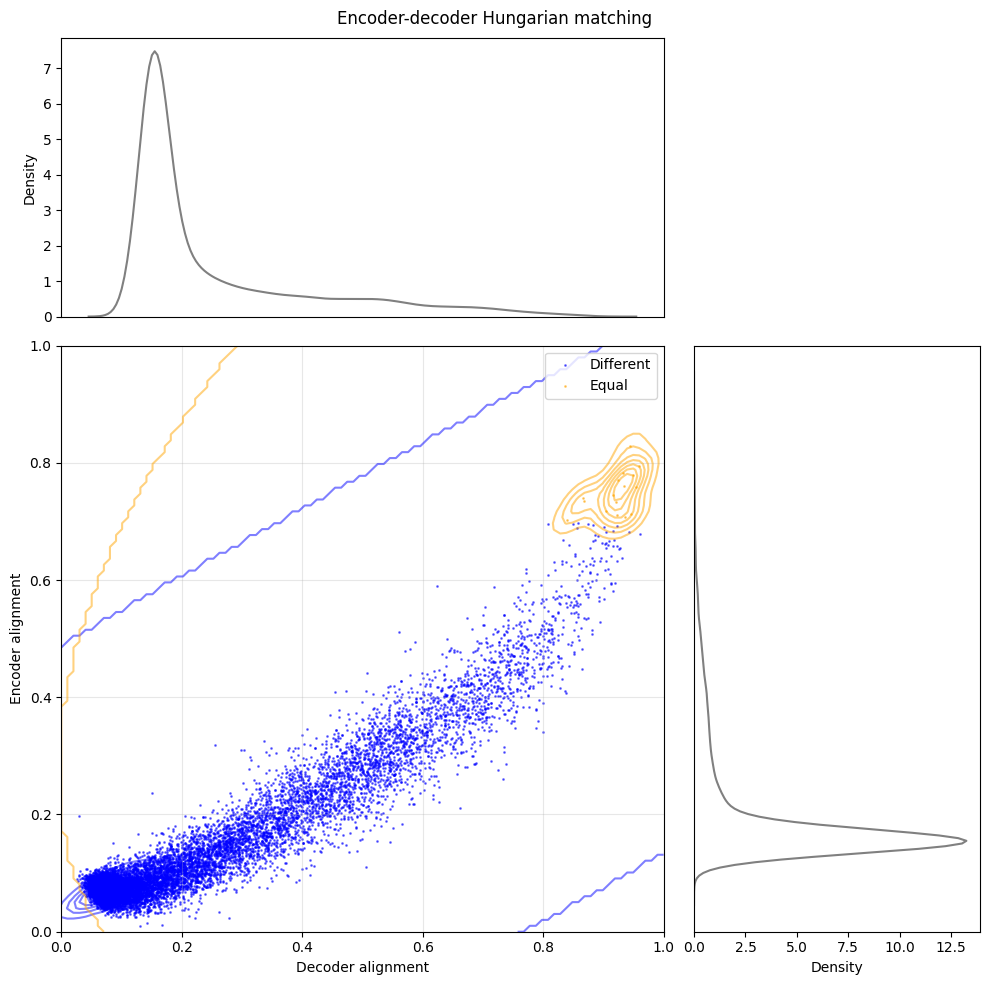

In [18]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

def compute_cosine_similarities(matrix1, matrix2):
    """Compute cosine similarity between corresponding vectors in two matrices."""
    norm1 = np.linalg.norm(matrix1, axis=1, keepdims=True)
    norm2 = np.linalg.norm(matrix2, axis=1, keepdims=True)
    matrix1_norm = matrix1 / norm1
    matrix2_norm = matrix2 / norm2
    return np.dot(matrix1_norm, matrix2_norm.T)

def create_alignment_plot(enc_ae, enc_gemma, dec_ae, dec_gemma):
    # Transpose encoder weights to match dimensions
    enc_ae = enc_ae.T  # Now (16384 x 2304)
    enc_gemma = enc_gemma.T  # Now (16384 x 2304)
    
    # Compute similarities
    enc_similarities = compute_cosine_similarities(enc_ae, enc_gemma)
    dec_similarities = compute_cosine_similarities(dec_ae, dec_gemma)
    
    # Get Hungarian matching
    average_similarities = (enc_similarities + dec_similarities) / 2
    row_ind, col_ind = linear_sum_assignment(-average_similarities)
    
    # Get matched similarities
    matched_enc_sims = enc_similarities[row_ind, col_ind]
    matched_dec_sims = dec_similarities[row_ind, col_ind]
    
    # Determine which matches are "equal"
    is_shared = (matched_enc_sims >= 0.7) & (matched_dec_sims >= 0.7)
    
    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    
    # Define the geometry for the scatter plot and marginals
    gs = plt.GridSpec(3, 3)
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_hist_x = fig.add_subplot(gs[0, :-1])
    ax_hist_y = fig.add_subplot(gs[1:, -1])
    
    # Plot points
    ax_scatter.scatter(matched_dec_sims[~is_shared], matched_enc_sims[~is_shared], 
                      c='blue', s=1, alpha=0.5, label='Different')
    ax_scatter.scatter(matched_dec_sims[is_shared], matched_enc_sims[is_shared], 
                      c='orange', s=1, alpha=0.5, label='Equal')
    
    # Add contours for each category
    for mask, color in [(~is_shared, 'blue'), (is_shared, 'orange')]:
        if np.sum(mask) > 10:
            x = matched_dec_sims[mask]
            y = matched_enc_sims[mask]
            xy = np.vstack([x, y])
            kde = gaussian_kde(xy)
            
            # Create a regular grid to evaluate kde
            xgrid = np.linspace(0, 1, 100)
            ygrid = np.linspace(0, 1, 100)
            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)
            
            # Plot contours
            ax_scatter.contour(Xgrid, Ygrid, Z, levels=7, colors=color, alpha=0.5)
    
    # Add marginal distributions
    sns.kdeplot(data=matched_dec_sims, ax=ax_hist_x, color='gray')
    sns.kdeplot(data=matched_enc_sims, ax=ax_hist_y, color='gray', vertical=True)
    
    # Adjust layouts
    ax_scatter.set_xlabel('Decoder alignment')
    ax_scatter.set_ylabel('Encoder alignment')
    ax_scatter.set_xlim(0, 1)
    ax_scatter.set_ylim(0, 1)
    ax_scatter.legend()
    ax_scatter.grid(True, alpha=0.3)
    
    # Remove labels from marginal plots
    ax_hist_x.set_xticks([])
    ax_hist_y.set_yticks([])
    
    plt.suptitle('Encoder-decoder Hungarian matching')
    
    # Calculate and print statistics
    total_latents = len(matched_enc_sims)
    shared_latents = np.sum(is_shared)
    print(f"Total latents: {total_latents}")
    print(f"Shared latents (cos sim ≥ 0.7): {shared_latents}")
    print(f"Fraction shared: {shared_latents/total_latents:.3f}")
    
    plt.tight_layout()
    return fig

# Run the analysis
fig = create_alignment_plot(enc_ae, enc_gemma, dec_ae, dec_gemma)
plt.show()

In [40]:
with torch.no_grad():
    target_act = activations[:128]
    print("Target act shape: ",target_act.shape)

    sae_acts = ae.encode(target_act.to(torch.float32))
    print("SAE acts shape: ", sae_acts.shape)
    recon = ae.decode(sae_acts)
    print("Recon shape: ", recon.shape)

    # Print MSE loss between target_act and recon
    loss = torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) **2)
    print("Loss: ", loss.item())

    variance_explained = 1 - torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) **2) / (target_act[:, 1:].to(torch.float32).var())
    print("Variance explained: ", variance_explained.item())

    l0 = (sae_acts > 0).sum(-1).float().mean().item()
    print("L0: ", l0)

Target act shape:  torch.Size([128, 128, 2304])
SAE acts shape:  torch.Size([128, 128, 16384])
Recon shape:  torch.Size([128, 128, 2304])
Loss:  3.697164297103882
Variance explained:  0.9093450903892517
L0:  61.49432373046875


In [43]:
with torch.no_grad():
    # Initialize lists to store statistics for each batch
    losses = []
    variances_explained = []
    l0_stats = []
    
    # Calculate number of batches
    batch_size = 128
    total_samples = activations.shape[0]
    num_batches = (total_samples + batch_size - 1) // batch_size  # Ceiling division
    
    for i in tqdm(range(num_batches)):
        # Get batch slice
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)
        target_act = activations[start_idx:end_idx]
        
        # Forward pass
        sae_acts = ae.encode(target_act.to(torch.float32))
        recon = ae.decode(sae_acts)
        
        # Calculate statistics
        # MSE Loss
        loss = torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) ** 2)
        losses.append(loss.item())
        
        # Variance explained
        var_exp = 1 - torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) ** 2) / (target_act[:, 1:].to(torch.float32).var())
        variances_explained.append(var_exp.item())
        
        # L0 statistic
        l0 = (sae_acts > 0).sum(-1).float().mean().item()
        l0_stats.append(l0)
    
    # Calculate final statistics
    mean_loss = np.mean(losses)
    mean_variance_explained = np.mean(variances_explained)
    mean_l0 = np.mean(l0_stats)
    
    # Calculate standard deviations
    std_loss = np.std(losses)
    std_variance_explained = np.std(variances_explained)
    std_l0 = np.std(l0_stats)
    
    # Print final results
    print(f"Final statistics over {total_samples} samples:")
    print(f"Mean Loss: {mean_loss:.6f} ± {std_loss:.6f}")
    print(f"Mean Variance Explained: {mean_variance_explained:.6f} ± {std_variance_explained:.6f}")
    print(f"Mean L0: {mean_l0:.2f} ± {std_l0:.2f}")

  0%|          | 0/79 [00:00<?, ?it/s]

Final statistics over 10000 samples:
Mean Loss: 3.600863 ± 0.137396
Mean Variance Explained: 0.910805 ± 0.001948
Mean L0: 59.91 ± 1.86


In [45]:
with torch.no_grad():
    # Initialize lists for both SAEs
    stats = {
        'ae': {'losses': [], 'variances_explained': [], 'l0_stats': []},
        'gemma': {'losses': [], 'variances_explained': [], 'l0_stats': []}
    }
    
    # Calculate number of batches
    batch_size = 128
    total_samples = activations.shape[0]
    num_batches = (total_samples + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches)):
        # Get batch slice
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)
        target_act = activations[start_idx:end_idx]
        target_act_float = target_act.to(torch.float32)
        
        # Process both SAEs
        for model_name, model in [('ae', ae), ('gemma', gemma)]:
            # Forward pass
            sae_acts = model.encode(target_act_float)
            recon = model.decode(sae_acts)
            
            # Calculate statistics
            loss = torch.mean((recon[:, 1:] - target_act_float[:, 1:]) ** 2)
            stats[model_name]['losses'].append(loss.item())
            
            var_exp = 1 - torch.mean((recon[:, 1:] - target_act_float[:, 1:]) ** 2) / (target_act_float[:, 1:].var())
            stats[model_name]['variances_explained'].append(var_exp.item())
            
            l0 = (sae_acts > 0).sum(-1).float().mean().item()
            stats[model_name]['l0_stats'].append(l0)
    
    # Print final results for both models
    print("Final statistics over {} samples:".format(total_samples))
    print("-" * 50)
    
    for model_name in ['ae', 'gemma']:
        mean_loss = np.mean(stats[model_name]['losses'])
        mean_variance_explained = np.mean(stats[model_name]['variances_explained'])
        mean_l0 = np.mean(stats[model_name]['l0_stats'])
        
        std_loss = np.std(stats[model_name]['losses'])
        std_variance_explained = np.std(stats[model_name]['variances_explained'])
        std_l0 = np.std(stats[model_name]['l0_stats'])
        
        print(f"\n{model_name.upper()} Statistics:")
        print(f"Mean Loss: {mean_loss:.6f} ± {std_loss:.6f}")
        print(f"Mean Variance Explained: {mean_variance_explained:.6f} ± {std_variance_explained:.6f}")
        print(f"Mean L0: {mean_l0:.2f} ± {std_l0:.2f}")

  0%|          | 0/79 [00:00<?, ?it/s]

Final statistics over 10000 samples:
--------------------------------------------------

AE Statistics:
Mean Loss: 3.600863 ± 0.137396
Mean Variance Explained: 0.910805 ± 0.001948
Mean L0: 59.91 ± 1.86

GEMMA Statistics:
Mean Loss: 7.013076 ± 0.093503
Mean Variance Explained: 0.826201 ± 0.002223
Mean L0: 120.56 ± 1.21
